In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical 
from scipy import stats
from sklearn.preprocessing import OneHotEncoder

In [2]:
data = pd.read_csv("data.csv")
data.head()

,Gender,CustomerAge,GeoCode,Make,MakeType,BodyType,MakeYear,Price,EngineSize,HorsePower,...,Weight,Distance,Deductible,claim,claim_no,Acceleration,FuelType,VehicleAge,EngineSize.1,exposure
0,M,36.0,375.0,Toyota,Corolla,Combi-Coupè,2005.0,221700.0,0.0,90.0,...,950.000000,16000.0,9000.0,0.0,0.0,13.722222,Gasoline,6.0,0.0,0.958248
1,M,35.0,5258.0,Skoda,Fabia,Stasjonsvogn,2010.0,212800.0,1422.0,80.0,...,876.923077,20000.0,9000.0,0.0,0.0,14.250000,Gasoline,1.0,1422.0,1.002053
2,K,50.0,5223.0,Ssangyong,Rodius,Kassevogn,2006.0,319900.0,2696.0,165.0,...,1596.153846,16000.0,9000.0,0.0,0.0,12.575758,Gasoline,6.0,2696.0,0.999316
3,M,36.0,3330.0,Volkswagen,Golf,Combi-Coupè,1999.0,199560.0,1595.0,100.0,...,826.153846,8000.0,9000.0,0.0,0.0,10.740000,Gasoline,12.0,1595.0,1.002053
4,M,40.0,6065.0,Audi,A4,Sedan,1999.0,339900.0,1896.0,110.0,...,988.461538,16000.0,9000.0,0.0,0.0,11.681818,Gasoline,12.0,1896.0,0.358658


Looking at the data, we'll start by doing some cleaning. 'EngineSize' and 'EngineSize.1' seem to be identical but with different tokens for NaN, so we'll remove one of those.  

In [3]:
data.drop('EngineSize.1',axis=1,inplace=True)

The 'SizeVehicleLWH'-column is in an inconvenient format. It seems reasonable to multiply these together to get a volume-like representation of size, which isn't too bad. We could also separate them into three regressors, but the three dimensions are probably heavily correlated anyway. 

In [4]:
# Successfully calculated volumes
vol = []
# Entries containing at least one zero-measurement
zero_vol = []
# Failed calculations for some other reason 
failed = []
for i,val in enumerate(data['SizeVehicleLWH']):
    # Split if the entry is a string
    if type(val) == str: 
        measurements = val.split() 
        if len(measurements) == 5: 
            length = measurements[0]
            width = measurements[2]
            height = measurements[4]
            volume = int(length)*int(width)*int(height)
            # Check that no measurement is zero. 
            if volume > 0: 
                vol.append((i,volume))
                continue    
            else: 
                zero_vol.append(i)
                continue
    # If the entry is not in the assumed format, add to a failed list. 
    failed.append(i)

Looking at the faulty entries, we see that most contain some zero values. Some are in another format but with reasonable values, so we'll extract and calculate these. 

In [5]:
for i in failed: 
    val = data['SizeVehicleLWH'][i]
    if type(val) == str: 
        measurements = val.split('x')
        if len(measurements) >= 3: 
            try: 
                length = int(measurements[0])
                width = int(measurements[1])
                height = int(measurements[2])
            except: 
                zero_vol.append(i)
                continue
            volume = length*width*height
            if volume > 0: 
                vol.append((i,volume))
                continue
    zero_vol.append(i)

In [6]:
volume_data = np.zeros(len(data))
for row,val in vol: 
    volume_data[row] = val

# Calculate the mean volume and replace the NA-values with this
mean_vol = np.mean([row[1] for row in vol])

for index in zero_vol: 
    volume_data[index] = mean_vol
    
data['Volume'] = volume_data

We can now drop the original column 'SizeVehicleLWH'. 

In [7]:
data.drop('SizeVehicleLWH',axis=1,inplace=True)

There are approx. 300 missing gender values. Let's just randomly assign input for these, since they are quite a few. Moreover, only 12 of those inputs have claims.  

In [8]:
failed = []
for i,val in enumerate(data['Gender']): 
    if type(val) is not str: 
        failed.append(i)
data.iloc[failed]

,Gender,CustomerAge,GeoCode,Make,MakeType,BodyType,MakeYear,Price,EngineSize,HorsePower,Weight,Distance,Deductible,claim,claim_no,Acceleration,FuelType,VehicleAge,exposure,Volume
8,NaN,45.0,4625.0,Mazda,3,Sedan,2007.0,225700.0,1598.0,105.0,903.846154,25000.0,9000.0,0.0,0.0,11.190476,Gasoline,4.0,0.999316,11616528.0
10,NaN,70.0,2022.0,Nissan,King Cab,Pickup,2003.0,234900.0,2488.0,133.0,1376.923077,12000.0,9000.0,0.0,0.0,13.458647,Gasoline,8.0,0.999316,16114980.0
11,NaN,53.0,4700.0,Renault,Megane,Stasjonsvogn,2004.0,239000.0,1598.0,115.0,934.615385,25000.0,9000.0,0.0,0.0,10.565217,Gasoline,7.0,0.999316,11628900.0
14,NaN,78.0,1536.0,Ford,Mondeo,Sedan,2006.0,290000.0,1998.0,115.0,1086.153846,30000.0,9000.0,0.0,0.0,12.278261,Gasoline,5.0,0.999316,12242659.0
20,NaN,44.0,5918.0,Volkswagen,Passat,Stasjonsvogn,1996.0,326600.0,1896.0,90.0,1003.846154,8000.0,9000.0,0.0,0.0,14.500000,Gasoline,15.0,0.999316,11788880.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6814,NaN,58.0,5582.0,Hyundai,Tucson,Stasjonsvogn,2005.0,371950.0,1991.0,112.0,1238.461538,20000.0,9000.0,0.0,0.0,14.375000,Gasoline,8.0,0.999316,13708347.0
6925,NaN,43.0,7058.0,Peugeot,Partner,Stasjonsvogn,2011.0,251300.0,1560.0,92.0,1084.615385,12000.0,9000.0,0.0,0.0,15.326087,Gasoline,2.0,0.908966,14745708.0
9108,NaN,73.0,693.0,Volkswagen,Polo,Combi-Coupè,2009.0,181040.0,1198.0,70.0,781.538462,8000.0,9000.0,0.0,0.0,14.514286,Gasoline,5.0,0.999316,9483705.0
9397,NaN,74.0,3409.0,Nissan,Qashqai,Combi-Coupè,2010.0,281000.0,1461.0,106.0,1082.307692,20000.0,9000.0,0.0,0.0,13.273585,Gasoline,4.0,0.999316,12380256.0


In [9]:
gender_col = np.where(data.columns == 'Gender')[0][0]
genders = ['M','K']
for i in failed: 
    data.iat[i,gender_col] = genders[np.random.randint(2)]

'CustomerAge' seems to be good, but some strings need to be converted to floats. 
Taking a look at the 'Make', we see that some samples have been mixed up in the 'Gender'-column. We'll sort that out. 

In [10]:
customerage_col = np.where(data.columns == "CustomerAge")[0][0]
failed = []
for i,val in enumerate(data['CustomerAge']):
    if type(val) is not float: 
        failed.append(i)
    elif np.isnan(val):
        failed.append(i)

for i in failed:
    try_float = float(data.iloc[i]['CustomerAge'])
    if np.isnan(try_float):
        try_float = np.random.randint(18,75)
    data.iat[i,customerage_col] = try_float
data.iloc[failed]

,Gender,CustomerAge,GeoCode,Make,MakeType,BodyType,MakeYear,Price,EngineSize,HorsePower,Weight,Distance,Deductible,claim,claim_no,Acceleration,FuelType,VehicleAge,exposure,Volume
415,K,42.0,4323.0,Mitsubishi,Outlander,Sport Utility Vehicle,2010.0,510900.0,2179.0,156.0,1350.000000,16000.0,9000.0,0.0,0.0,11.25,Gasoline,1.0,0.344969,1.445832e+07
1305,"K,49,9303,Dethleffs,""2450, 1,9TD"",Campingbil,1...",48.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.237792e+07
1716,"M,59,981,Knaus,""Sport Traveller 2,0"",Campingbi...",62.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.237792e+07
1717,"M,59,981,Knaus,""Sport Traveller 2,0"",Campingbi...",62.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.237792e+07
2224,K,72.0,7320.0,Subaru,Forester,Stasjonsvogn,2005.0,319900.0,1994.0,125.0,1046.153846,20000.0,9000.0,0.0,0.0,10.88,Gasoline,6.0,0.331280,1.231137e+07
4626,"K,49,9303,Dethleffs,""2450, 1,9TD"",Campingbil,1...",52.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.237792e+07
4882,"M,59,981,Knaus,""Sport Traveller 2,0"",Campingbi...",34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.237792e+07
5986,"M,59,981,Knaus,""Sport Traveller 2,0"",Campingbi...",54.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.237792e+07
9957,"M,59,981,Knaus,""Sport Traveller 2,0"",Campingbi...",46.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.237792e+07


In [11]:
failed = []
for i,val in enumerate(data['Make']): 
    if type(val) is not str: 
        failed.append(i)

Row 571 doesn't have a lot of info and probably doesn't contribute too much, so let's drop it.

In [12]:
data.drop(571,inplace=True)
failed = failed[1:]
failed = [index - 1 for index in failed]

In [13]:
# Extract the data that had been clustered together in the 'Gender'-column 
for i in failed:
    row = data.iloc[i].copy()
    vals = row[0]
    vals = vals.split(',')
    row['Gender'] = vals[0]
    row['exposure'] = float(vals[-1])
    row['FuelType'] = vals[-4]
    row['Acceleration'] = float(vals[-5])
    row['claim_no'] = vals[-6]
    row['claim'] = vals[-7]
    row['Deductible'] = float(vals[-8])
    row['Distance'] = float(vals[-9])
    row['Weight'] = float(vals[-10])
    row['Volume'] = mean_vol   # The measurements are zero, so take the average instead 
    row['HorsePower'] = float(vals[-12])
    row['EngineSize'] = float(vals[-13])
    row['Price'] = float(vals[-14])
    row['MakeYear'] = 1998     # These missing entries are all from similar vehicles with year 1998
    row['BodyType'] = vals[-16]
    row['MakeType'] = "".join(vals[4:-16])
    row['Make'] = vals[3]
    row['CustomerAge'] = float(vals[1])
    row['GeoCode'] = float(vals[2])
    row['VehicleAge'] = float(2020 - row['MakeYear'])  # The newest car is from 2020, so I guess that's 'today'. 
    data.iloc[i] = row

In [14]:
data.iloc[failed]

,Gender,CustomerAge,GeoCode,Make,MakeType,BodyType,MakeYear,Price,EngineSize,HorsePower,Weight,Distance,Deductible,claim,claim_no,Acceleration,FuelType,VehicleAge,exposure,Volume
1305,K,49.0,9303.0,Dethleffs,"""2450 19TD""",Campingbil,1998.0,332000.0,1929.0,82.0,1842.307692,8000.0,9000.0,0,0,29.207317,Gasoline,22.0,1.002053,1.237792e+07
1716,M,59.0,981.0,Knaus,"""Sport Traveller 20""",Campingbil,1998.0,500000.0,1997.0,85.0,1855.384615,12000.0,9000.0,0,0,28.376471,Gasoline,22.0,0.084873,1.237792e+07
1717,M,59.0,981.0,Knaus,"""Sport Traveller 20""",Campingbil,1998.0,500000.0,1997.0,85.0,1855.384615,8000.0,9000.0,0,0,28.376471,Gasoline,22.0,0.914442,1.237792e+07
4626,K,49.0,9303.0,Dethleffs,"""2450 19TD""",Campingbil,1998.0,332000.0,1929.0,82.0,1842.307692,8000.0,9000.0,0,0,29.207317,Gasoline,22.0,0.246407,1.237792e+07
4882,M,59.0,981.0,Knaus,"""Sport Traveller 20""",Campingbil,1998.0,500000.0,1997.0,85.0,1855.384615,8000.0,9000.0,0,0,28.376471,Gasoline,22.0,1.002053,1.237792e+07
5986,M,59.0,981.0,Knaus,"""Sport Traveller 20""",Campingbil,1998.0,500000.0,1997.0,85.0,1855.384615,8000.0,9000.0,0,0,28.376471,Gasoline,22.0,0.999316,1.237792e+07
9957,M,59.0,981.0,Knaus,"""Sport Traveller 20""",Campingbil,1998.0,500000.0,1997.0,85.0,1855.384615,8000.0,9000.0,0,0,28.376471,Gasoline,22.0,0.386037,1.237792e+07


In [15]:
geocode = np.zeros(len(data))
failed = []
for i,val in enumerate(data['GeoCode']): 
    if np.isnan(val): 
        failed.append(i)
    else: 
        geocode[i] = int(val)
# Only a few areas are NaN, so let's replace these with the most common one code
mode = stats.mode(geocode)[0][0]
for i in failed: 
    geocode[i] = mode
data['GeoCode'] = geocode

If 'EngineSize' is set as zero - despite the car not being an electric car - well try to replace it with the engine size of a similar model with same amount of horsepowers. 

In [16]:
failed = []
electric_failed = []
for i,val in enumerate(data['EngineSize']): 
    if data.iloc[i]['FuelType'] == 'Electric':
        electric_failed.append(i)
    elif (val  == 0):
        failed.append(i)
    elif type(val) == float:
        if(np.isnan(val)):
            failed.append(i)

In [17]:
still_failed = []
engine_col = np.where(data.columns == 'EngineSize')[0][0]

for i in failed: 
    make = data.iloc[i]['MakeType']
    HP = data.iloc[i]['HorsePower']
    similar = data.loc[(data['MakeType'] == make) & 
                       (data['HorsePower'] == HP) & 
                       (data['EngineSize'] != 0)]
    if len(similar) > 0:
        try_size = similar.iloc[0]['EngineSize'] 
        if not np.isnan(try_size):
            data.iat[i,engine_col] = try_size
        else: 
            still_failed.append(i)
    else:
        still_failed.append(i)

There are also some 'EngineSize' which are strings, but reasonable values. These should be converted. 

In [18]:
for i,val in enumerate(data['EngineSize']):
    if type(val) == str: 
        data.iat[i,engine_col] = float(val)

We'll interpolate the ones that are still failed or electric by horsepower. We need to specify horsepower manually on two rows, we'll just pick a later model of the same brand. 

In [19]:
hp_col = np.where(data.columns == 'HorsePower')[0][0]
data.iat[373,hp_col] = 75
data.iat[2661,hp_col] = 75

In [20]:
df = data.loc[:,('HorsePower','EngineSize')]
df.set_index('HorsePower',inplace=True)
df['EngineSize'].replace(0,np.nan,inplace=True)
df.interpolate(method='index',inplace=True)
df.reset_index(inplace=True)

for i in electric_failed: 
    data.iat[i,engine_col] = df.iloc[i]['EngineSize']

for i in still_failed:
    data.iat[i,engine_col] = df.iloc[i]['EngineSize']

The field 'VehicleAge' doesn't seem up to date, there are for instance lots of "0.0" entries for rows with 'MakeYear' different from 2020. We assign new values to 'VehicleAge' as 2020 - 'MakeYear'.

In [21]:
vehicle_age = 2020 - data['MakeYear']
data['VehicleAge'] = vehicle_age
data.drop('MakeYear',axis=1,inplace=True)

In [22]:
failed = []
for i,val in enumerate(data['VehicleAge']):
    if np.isnan(val):
        failed.append(i)

There are still a few values missing in 'VehicleAge'. This should be fairly correlated with 'Distance', so we'll just divide by the average distance driven per year to estimate the VehicleAge. 

In [23]:
# Calculate average driven distance per year 
distance_per_year = np.zeros(len(data))
for i,entry in enumerate(data.loc[:,('VehicleAge','Distance')].values):
    if (entry[0] != 0) and (not np.isnan(entry).any()): 
        distance_per_year[i] = (entry[1] / entry[0])
    else: 
        distance_per_year[i] = 1000
avg_distance_per_year = np.mean(distance_per_year) 

In [24]:
age_col = np.where(data.columns == 'VehicleAge')[0][0]

for i in failed: 
    data.iat[i,age_col] = np.round(data.iloc[i]['Distance'] / avg_distance_per_year)
data.iloc[failed]

,Gender,CustomerAge,GeoCode,Make,MakeType,BodyType,Price,EngineSize,HorsePower,Weight,Distance,Deductible,claim,claim_no,Acceleration,FuelType,VehicleAge,exposure,Volume
229,M,60.0,1768.0,Mitsubishi,Eclipse RS,Coupe,400000.0,2351.0,150.0,1023.076923,16000.0,9000.0,0,0,8.866667,Gasoline,8.0,0.999316,1.237792e+07
2097,M,60.0,1768.0,Mitsubishi,Eclipse RS,Coupe,400000.0,2351.0,150.0,1023.076923,16000.0,9000.0,0,0,8.866667,Gasoline,8.0,1.002053,1.237792e+07
6667,M,60.0,1768.0,Mitsubishi,Eclipse RS,Coupe,400000.0,2351.0,150.0,1023.076923,16000.0,9000.0,0,0,8.866667,Gasoline,8.0,0.172485,1.237792e+07
23052,M,74.0,3741.0,Knaus,Sun,Campingbil,1000000.0,2953.0,134.0,2153.846154,8000.0,9000.0,0,0,20.895522,Gasoline,4.0,0.462697,1.237792e+07
27798,M,74.0,3741.0,Knaus,Sun,Campingbil,1000000.0,2953.0,134.0,2153.846154,8000.0,9000.0,0,0,20.895522,Gasoline,4.0,0.605065,1.237792e+07
30613,M,74.0,3741.0,Knaus,Sun,Campingbil,1000000.0,2953.0,134.0,2153.846154,8000.0,9000.0,0,0,20.895522,Gasoline,4.0,0.372348,1.237792e+07


In [25]:
data.loc[data['MakeType'] == "106"]

,Gender,CustomerAge,GeoCode,Make,MakeType,BodyType,Price,EngineSize,HorsePower,Weight,Distance,Deductible,claim,claim_no,Acceleration,FuelType,VehicleAge,exposure,Volume
373,M,72.0,5918.0,Peugeot,106,Combi-coupe,148000.0,1364.0,75.0,842.307692,16000.0,9000.0,0,0,NaN,Gasoline,22.0,0.999316,1.237792e+07
2662,M,72.0,5918.0,Peugeot,106,Combi-coupe,148000.0,1364.0,75.0,842.307692,16000.0,9000.0,0,0,NaN,Gasoline,22.0,0.084873,1.237792e+07


In [26]:
df = data.loc[:,('HorsePower','EngineSize')]
df.set_index('HorsePower',inplace=True)
df['EngineSize'].replace(0,np.nan,inplace=True)
df.interpolate(method='index',inplace=True)
df.reset_index(inplace=True)

engine_col = np.where(data.columns == 'EngineSize')[0][0]

for i in electric_failed: 
    data.iat[i,engine_col] = df.iloc[i]['EngineSize']

for i in still_failed:
    data.iat[i,engine_col] = df.iloc[i]['EngineSize']

There are only two NaN's in 'MakeType'. We'll manually replace those with reasonable choices from similar data. 

In [27]:
failed = []
for i,val in enumerate(data['MakeType']):
    if type(val) == float: 
        failed.append(i)
    elif val == "": 
        print(val,i)
data.iloc[failed]

,Gender,CustomerAge,GeoCode,Make,MakeType,BodyType,Price,EngineSize,HorsePower,Weight,Distance,Deductible,claim,claim_no,Acceleration,FuelType,VehicleAge,exposure,Volume
5412,M,47.0,3296.0,Think,NaN,Combi-Coupé,196000.0,1364.0,37.0,738.461538,16000.0,9000.0,0,0,25.945946,Electric,19.0,0.060233,1.237792e+07
14769,M,57.0,4051.0,Volvo,NaN,Sedan,60000.0,1700.0,70.0,746.153846,8000.0,9000.0,0,0,13.857143,Gasoline,62.0,0.364134,1.237792e+07


In [28]:
maketype_col = np.where(data.columns == 'MakeType')[0][0]
data.iat[failed[0],maketype_col] = 'City'
data.iat[failed[1],maketype_col] = '850'
data.iloc[failed]


,Gender,CustomerAge,GeoCode,Make,MakeType,BodyType,Price,EngineSize,HorsePower,Weight,Distance,Deductible,claim,claim_no,Acceleration,FuelType,VehicleAge,exposure,Volume
5412,M,47.0,3296.0,Think,City,Combi-Coupé,196000.0,1364.0,37.0,738.461538,16000.0,9000.0,0,0,25.945946,Electric,19.0,0.060233,1.237792e+07
14769,M,57.0,4051.0,Volvo,850,Sedan,60000.0,1700.0,70.0,746.153846,8000.0,9000.0,0,0,13.857143,Gasoline,62.0,0.364134,1.237792e+07


In [29]:
failed = []
for i,val in enumerate(data['BodyType']): 
    if type(val) is not str:
        failed.append(i)
data.iloc[failed]

,Gender,CustomerAge,GeoCode,Make,MakeType,BodyType,Price,EngineSize,HorsePower,Weight,Distance,Deductible,claim,claim_no,Acceleration,FuelType,VehicleAge,exposure,Volume
12,M,73.0,1832.0,Ford,MONDEO GLX 16V,NaN,250000.0,1560.0,140.0,973.076923,20000.0,9000.0,0,0,9.035714,Gasoline,26.0,0.999316,1.237792e+07
41,K,62.0,1816.0,Audi,80,NaN,200000.0,1364.0,89.0,926.923077,16000.0,9000.0,0,0,13.539326,Gasoline,28.0,0.999316,1.237792e+07
196,M,69.0,9845.0,Toyota,STARLET 1.3 XLI,NaN,150000.0,1364.0,74.0,942.307692,12000.0,9000.0,0,0,16.554054,Gasoline,28.0,0.999316,1.237792e+07
316,M,65.0,4846.0,Volkswagen,GOLF GL,NaN,150000.0,1364.0,74.0,688.461538,8000.0,9000.0,0,0,12.094595,Gasoline,30.0,0.024641,1.237792e+07
717,M,73.0,3268.0,Toyota,CARINA E 2.0 D XL,NaN,200000.0,1364.0,73.0,950.000000,8000.0,9000.0,0,0,16.917808,Gasoline,27.0,1.002053,1.237792e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32416,K,75.0,1721.0,Challenger,EDEN 312,NaN,850000.0,2953.0,134.0,2161.538462,8000.0,9000.0,0,0,20.970149,Gasoline,14.0,0.158795,1.237792e+07
32488,M,50.0,1400.0,Mitsubishi,Outlander,NaN,480000.0,1998.0,121.0,1392.307692,16000.0,9000.0,0,0,14.958678,Gasoline,6.0,0.002738,1.237792e+07
32493,M,70.0,4021.0,Challenger,C276 Genesis Ford M1,NaN,850000.0,2198.0,152.0,2170.769231,8000.0,9000.0,0,0,18.565789,Gasoline,4.0,0.002738,4.991000e+07
32604,K,35.0,982.0,Toyota,Prius SW20,NaN,250000.0,1497.0,110.0,1000.000000,12000.0,9000.0,0,0,11.818182,Gasoline,13.0,0.046543,1.237792e+07


In [30]:
bodytype_col = np.where(data.columns == 'BodyType')[0][0]

for i in failed: 
    replaced = False
    make = data.iloc[i]['Make']
    maketype = data.iloc[i]['MakeType']
    similar = data.loc[(data['Make'] == make) & 
                      (data['MakeType'] == maketype) & 
                      (data.index != i)]
    for bodytype in similar['BodyType']:
        if type(bodytype) is str: 
            data.iat[i,bodytype_col] = bodytype
            replaced = True
            break
    if not replaced: 
        # If no similar 'MakeType' was found, just take the most common from the Make. 
        most_common = stats.mode(data.loc[data['Make'] == make]['BodyType'])[0][0]
        if type(most_common) is str: 
            data.iat[i,bodytype_col] = most_common
        # If 'most_common' is not string, then assign "NA". 
        data.iat[i,bodytype_col] = "NA"
data.iloc[failed]

,Gender,CustomerAge,GeoCode,Make,MakeType,BodyType,Price,EngineSize,HorsePower,Weight,Distance,Deductible,claim,claim_no,Acceleration,FuelType,VehicleAge,exposure,Volume
12,M,73.0,1832.0,Ford,MONDEO GLX 16V,NA,250000.0,1560.0,140.0,973.076923,20000.0,9000.0,0,0,9.035714,Gasoline,26.0,0.999316,1.237792e+07
41,K,62.0,1816.0,Audi,80,Sedan,200000.0,1364.0,89.0,926.923077,16000.0,9000.0,0,0,13.539326,Gasoline,28.0,0.999316,1.237792e+07
196,M,69.0,9845.0,Toyota,STARLET 1.3 XLI,NA,150000.0,1364.0,74.0,942.307692,12000.0,9000.0,0,0,16.554054,Gasoline,28.0,0.999316,1.237792e+07
316,M,65.0,4846.0,Volkswagen,GOLF GL,NA,150000.0,1364.0,74.0,688.461538,8000.0,9000.0,0,0,12.094595,Gasoline,30.0,0.024641,1.237792e+07
717,M,73.0,3268.0,Toyota,CARINA E 2.0 D XL,NA,200000.0,1364.0,73.0,950.000000,8000.0,9000.0,0,0,16.917808,Gasoline,27.0,1.002053,1.237792e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32416,K,75.0,1721.0,Challenger,EDEN 312,NA,850000.0,2953.0,134.0,2161.538462,8000.0,9000.0,0,0,20.970149,Gasoline,14.0,0.158795,1.237792e+07
32488,M,50.0,1400.0,Mitsubishi,Outlander,Sport Utility Vehicle,480000.0,1998.0,121.0,1392.307692,16000.0,9000.0,0,0,14.958678,Gasoline,6.0,0.002738,1.237792e+07
32493,M,70.0,4021.0,Challenger,C276 Genesis Ford M1,NA,850000.0,2198.0,152.0,2170.769231,8000.0,9000.0,0,0,18.565789,Gasoline,4.0,0.002738,4.991000e+07
32604,K,35.0,982.0,Toyota,Prius SW20,NA,250000.0,1497.0,110.0,1000.000000,12000.0,9000.0,0,0,11.818182,Gasoline,13.0,0.046543,1.237792e+07


Seems like the only trouble with the price data was that some were formatted as strings rather than floats. 

In [31]:
price_col = np.where(data.columns == 'Price')[0][0]
for i,val in enumerate(data['Price']):
    if type(val) == str: 
        data.iat[i,price_col] = float(val)

In [32]:
hp_col = np.where(data.columns == 'HorsePower')[0][0]
for i,val in enumerate(data['HorsePower']):
    if type(val) is not float: 
        data.iat[i,hp_col] = float(val)

In [33]:
dist_col = np.where(data.columns == 'Distance')[0][0]
failed = []
for i,val in enumerate(data['Distance']):
    if type(val) == str: 
        data.iat[i,dist_col] = float(val)
    elif np.isnan(val):
        failed.append(i)

In [34]:
# Replace missing values with 'VehicleAge' * avg_distance_per_year
for i in failed: 
    data.iat[i,dist_col] = data.iloc[i]['VehicleAge'] * avg_distance_per_year

In [35]:
deduct_col = np.where(data.columns == 'Deductible')[0][0]
for i,val in enumerate(data['Deductible']): 
    if type(val) is not float: 
        data.iat[i,deduct_col] = float(val)

In [36]:
failed = []
acc_col = np.where(data.columns == 'Acceleration')[0][0]
for i,val in enumerate(data['Acceleration']): 
    if type(val) is not float: 
        data.iat[i,acc_col] = float(val)
    elif np.isnan(val): 
        failed.append(i)
data.iloc[failed]

,Gender,CustomerAge,GeoCode,Make,MakeType,BodyType,Price,EngineSize,HorsePower,Weight,Distance,Deductible,claim,claim_no,Acceleration,FuelType,VehicleAge,exposure,Volume
373,M,72.0,5918.0,Peugeot,106,Combi-coupe,148000.0,1364.0,75.0,842.307692,16000.0,9000.0,0,0,NaN,Gasoline,22.0,0.999316,1.237792e+07
2662,M,72.0,5918.0,Peugeot,106,Combi-coupe,148000.0,1364.0,75.0,842.307692,16000.0,9000.0,0,0,NaN,Gasoline,22.0,0.084873,1.237792e+07


Only two cars failed in 'Acceleration', so let's moanually adjust these to similar models. Apparantly roughly 13. 

In [37]:
for i in failed: 
    data.iat[i,acc_col] = 13

In [38]:
for i,val in enumerate(data['FuelType']): 
    if type(val) is not str: 
        print(i)

Now everything seems in order, so let's normalize and create categorical variables. 

In [39]:
ohe_gender = OneHotEncoder(sparse=False,categories='auto')
ohe_geocode = OneHotEncoder(sparse=False,categories='auto')
ohe_make = OneHotEncoder(sparse=False,categories='auto')
ohe_maketype = OneHotEncoder(sparse=False,categories='auto')
ohe_bodytype = OneHotEncoder(sparse=False,categories='auto')
ohe_fueltype = OneHotEncoder(sparse=False,categories='auto')

gender = np.asarray(data['Gender']).reshape(len(data),1)
onehot_gender = ohe_gender.fit_transform(gender)

geocode = np.asarray(data['GeoCode']).reshape(len(data),1)
onehot_geocode = ohe_geocode.fit_transform(geocode)

make = np.asarray(data['Make']).reshape(len(data),1)
onehot_make = ohe_make.fit_transform(make)

maketype = np.asarray(data['MakeType']).reshape(len(data),1)
onehot_maketype = ohe_maketype.fit_transform(maketype)

bodytype = np.asarray(data['BodyType']).reshape(len(data),1)
onehot_bodytype = ohe_bodytype.fit_transform(bodytype)

fueltype = np.asarray(data['FuelType']).reshape(len(data),1)
onehot_fueltype = ohe_fueltype.fit_transform(fueltype)

# Concatinate to a numpy-array. 
# We only choose a subset of the features, after some testing
x = np.concatenate((onehot_gender,
#                    onehot_geocode,
                    onehot_make,
#                    onehot_maketype,
#                    onehot_bodytype,
                    onehot_fueltype),axis=1)

In [40]:
# Normalize continuous featuress to [0,1]

def normalize(dat):
    # If we want to use this on not yet available data, we'd want to keep track
    # of the normalizing parameters used for the training data. 
    minimum = min(dat)
    maximum = max(dat)
    norm_dat = []
    for val in dat: 
        norm_dat.append((val - minimum)/(maximum - minimum))
    return np.asarray(norm_dat).reshape(len(data),1)

# This is where we choose the continuous features we want to include. 
# After some testing, the below features are chosen. 

continuous_cols = ['CustomerAge','Price',
                   'HorsePower','Weight','Distance',
                   'Acceleration','VehicleAge',
                   'exposure']

for col in continuous_cols: 
    x = np.concatenate((x,normalize(data[col])),axis=1)

Apparantly the claim size is negative for 21 values. I'm not sure if I should interpret these as just having the wrong sign or some other error, but I'll just set them to zero. 

In [41]:
# Normalize the targets. 
claim_no = np.asarray(data['claim_no'].astype(float)).reshape(len(data),1)
claim_col = np.where(data.columns == 'claim')[0][0]
neg_claims = np.where(data['claim'].astype(float) < 0)[0]
for i in neg_claims: 
    data.iat[i,claim_col] = 0
claim_size = normalize(data['claim'].astype(float))

In [42]:
# Shuffle data for train and test 
indices = np.arange(len(x))
np.random.shuffle(indices)
train_size = 30000

x_train = x[:train_size]
claim_no_train = claim_no[:train_size]

x_test = x[train_size:]
claim_no_test = claim_no[train_size:]

# Models
## Number of claims
We'll first model the number of claims for a given customer. Since the number of samples are rather low (~30,000) we'll use a quite shallow neural network with a softmax activation function.
Since the maximum number of claims so far has been 3, we'll construct this as a multi-class classification problem with classes {0,1,2,3,4}. 

In [43]:
# Model to evaluate how many claims there will be for a given customer. 
nbr_classes = 5

m_nbr = Sequential()

m_nbr.add(layers.Dense(8,activation='relu',
                      input_shape=([x.shape[-1],])))
# Add dropout regularization with probability 0.2 to reduce overfitting
m_nbr.add(layers.Dropout(0.2))

m_nbr.add(layers.Dense(10,activation='relu'))
m_nbr.add(layers.Dropout(0.2))


m_nbr.add(layers.Dense(nbr_classes,activation='softmax'))

m_nbr.compile(optimizer='rmsprop',loss='sparse_categorical_crossentropy')
m_nbr.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 672       
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                90        
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 55        
Total params: 817
Trainable params: 817
Non-trainable params: 0
_________________________________________________________________


Train on 24000 samples, validate on 6000 samples
Epoch 1/10
24000/24000 [==============================] - 7s 274us/sample - loss: 0.3169 - val_loss: 0.2159
Epoch 2/10
24000/24000 [==============================] - 6s 240us/sample - loss: 0.2125 - val_loss: 0.2133
Epoch 3/10
24000/24000 [==============================] - 7s 273us/sample - loss: 0.2096 - val_loss: 0.2147
Epoch 4/10
24000/24000 [==============================] - 4s 164us/sample - loss: 0.2071 - val_loss: 0.2124
Epoch 5/10
24000/24000 [==============================] - 4s 166us/sample - loss: 0.2073 - val_loss: 0.2135
Epoch 6/10
24000/24000 [==============================] - 4s 168us/sample - loss: 0.2071 - val_loss: 0.2134
Epoch 7/10
24000/24000 [==============================] - 4s 185us/sample - loss: 0.2072 - val_loss: 0.2140
Epoch 8/10
24000/24000 [==============================] - 4s 167us/sample - loss: 0.2072 - val_loss: 0.2141
Epoch 9/10
24000/24000 [==============================] - 7s 293us/sample - loss: 0.206

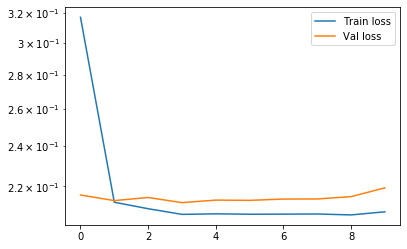

In [44]:
m_nbr_history = m_nbr.fit(x_train,claim_no_train,
                         batch_size=16,
                         epochs=10,
                         validation_split=0.2)
plt.plot(m_nbr_history.history['loss'],label='Train loss')
plt.plot(m_nbr_history.history['val_loss'],label='Val loss')
plt.yscale('log')
plt.legend()
plt.show()

In [45]:
# Evaluate on the test set 
m_nbr.evaluate(x_test,claim_no_test,verbose=0)

0.10596325234476808

## Claim Severity
For the claim severity, the samples which has resulted in a claim must be extracted. We'll then do a similar approach to the model above, but with a linear activation function so the output space is unbounded. 

In [46]:
claim_indices = np.where(data['claim'] != 0)[0]
claim_train_nbr = 1200

x_claim_train = x[claim_indices[:claim_train_nbr]]
x_claim_test = x[claim_indices[claim_train_nbr:]]

claim_size_train = claim_size[claim_indices[:claim_train_nbr]]
claim_size_test = claim_size[claim_indices[claim_train_nbr:]]

In [47]:
m_size = Sequential()

m_size.add(layers.Dense(10, activation='relu',
                        input_shape=[x_claim_train.shape[-1],]))

m_size.add(layers.Dense(20,activation='relu'))
m_size.add(layers.Dropout(0.2))

m_size.add(layers.Dense(1,activation='linear'))

m_size.compile(optimizer='rmsprop',loss='mse')
m_size.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 10)                840       
_________________________________________________________________
dense_4 (Dense)              (None, 20)                220       
_________________________________________________________________
dropout_2 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 21        
Total params: 1,081
Trainable params: 1,081
Non-trainable params: 0
_________________________________________________________________


Train on 960 samples, validate on 240 samples
Epoch 1/30
960/960 [==============================] - 2s 2ms/sample - loss: 0.0114 - val_loss: 0.0083
Epoch 2/30
960/960 [==============================] - 0s 207us/sample - loss: 0.0093 - val_loss: 0.0080
Epoch 3/30
960/960 [==============================] - 0s 209us/sample - loss: 0.0087 - val_loss: 0.0078
Epoch 4/30
960/960 [==============================] - 0s 191us/sample - loss: 0.0085 - val_loss: 0.0076
Epoch 5/30
960/960 [==============================] - 0s 225us/sample - loss: 0.0083 - val_loss: 0.0076
Epoch 6/30
960/960 [==============================] - 0s 192us/sample - loss: 0.0081 - val_loss: 0.0077
Epoch 7/30
960/960 [==============================] - 0s 207us/sample - loss: 0.0081 - val_loss: 0.0076
Epoch 8/30
960/960 [==============================] - 0s 209us/sample - loss: 0.0081 - val_loss: 0.0077
Epoch 9/30
960/960 [==============================] - 0s 208us/sample - loss: 0.0082 - val_loss: 0.0076
Epoch 10/30
960/960 

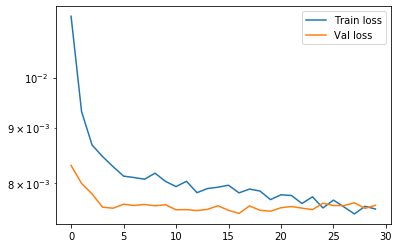

In [48]:
m_size_history = m_size.fit(x_claim_train,claim_size_train,
                         batch_size=16,
                         epochs=30,
                         validation_split=0.2)
plt.plot(m_size_history.history['loss'],label='Train loss')
plt.plot(m_size_history.history['val_loss'],label='Val loss')
plt.yscale('log')
plt.legend()
plt.show()

In [49]:
# Evaluate on the test set
m_size.evaluate(x_claim_test,claim_size_test,verbose=0)

0.012414785198867321

In [50]:
def normalize_input(val,name): 
    minimum = min(data[name])
    maximum = max(data[name])
    return np.asarray((val - minimum)/(maximum - minimum)).reshape(1,1)
# Expects input as: [Gender, Make, Fueltype, CustomerAge, Price, 
# HorsePower, Weight, Distance, Acceleration, VehicleAge, exposure]

def interpret_size(size):
    minimum = min(data['claim'].astype(float))
    maximum = max(data['claim'].astype(float))
    return (maximum - minimum)*size + minimum
    
def prepare_input(entry):
    
    inp = ohe_gender.transform(np.asarray([entry['Gender']]).reshape(1,1))
    inp = np.concatenate((inp,ohe_make.transform(np.array(entry['Make']).reshape(1,1))),axis=1)
    inp = np.concatenate((inp,ohe_fueltype.transform(np.array([entry['FuelType']]).reshape(1,1))),axis=1)
    
    inp = np.concatenate((inp,normalize_input(entry['CustomerAge'],'CustomerAge')),axis=1)
    inp = np.concatenate((inp,normalize_input(entry['Price'],'Price')),axis=1)
    inp = np.concatenate((inp,normalize_input(entry['HorsePower'],'HorsePower')),axis=1)
    inp = np.concatenate((inp,normalize_input(entry['Weight'],'Weight')),axis=1)
    inp = np.concatenate((inp,normalize_input(entry['Distance'],'Distance')),axis=1)
    inp = np.concatenate((inp,normalize_input(entry['Acceleration'],'Acceleration')),axis=1)
    inp = np.concatenate((inp,normalize_input(entry['VehicleAge'],'VehicleAge')),axis=1)
    inp = np.concatenate((inp,normalize_input(entry['exposure'],'exposure')),axis=1)
    return inp.reshape(inp.shape[-1])

## Out-of-sample validity check
We can now test the model with a new sample with the desired values. 

In [51]:
entry = {'Gender':'M',
         'Make': 'Volkswagen',
         'FuelType': 'Gasoline',
         'CustomerAge': 45,
         'Price': 100000,
         'HorsePower': 120,
         'Weight': 2000,          # In kgs
         'Distance': 220000,      # In km
         'Acceleration': 10,
         'VehicleAge': 10,  
         'exposure': 1}
x_inp = prepare_input(entry)

# Calculate the probability of the number of claims 
pred_nbr = m_nbr.predict([[x_inp]])
# Calculate the expected size of the claim
pred_size_raw = m_size.predict([[x_inp]])
# Interpret the claim size, i.e. 'un-normalize'
pred_size = interpret_size(pred_size_raw)

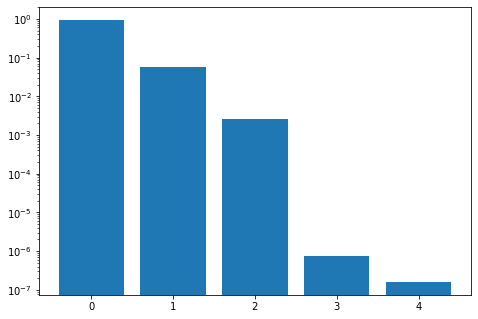

In [52]:
# We can now estimate the probability of the number of claims as,
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = np.arange(0,nbr_classes)
ax.bar(langs,pred_nbr[0])
plt.yscale('log')
plt.show()

Finally, we can calculate the expected claim cost as the expected claim size multiplied by the expected number of claims. 

In [53]:
expected_cost = sum(pred_nbr[0][1:]) * pred_size[0][0]
expected_cost = 0
for i,prob in enumerate(pred_nbr[0]):
    expected_cost += i * prob * pred_size[0][0]
print("The expected cost is: {}".format(round(expected_cost)))

The expected cost is: 4607.0


# Conclusion

The model above gives reasonable values for different inputs. A subset of the available features was chosen after a few different model evaluations, but could be done more systematically. 
The evaluations on the test sets show that the model generalizes fairly well. It should however be noted that the models used are the last models achieved after fitting, whereas the models with the lowest validation score during the training ideally should be selected. 


## Limitations

The obvious drawback of this approach is the lack of statistical measures. One way to obtain a standard deviation of a calculated price is to train several models on the same data and make predictions. Since the training of the model is stochastic, the models will be different. A mean over several predictions would give a better estimate and also gives a measure of the standard deviation of a prediction.  

It should also be noted that the size of the dataset is a limiting factor. Especially in the modelling of claim sizes, since the sample size is approximately 1700 values. 

Finally, the optimization of hyper parameters was conducted rather primitively and could be improved with a more systematic approach of evaluating different sets of hyper parameters. 